In [1]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from softcvi_validation import utils
from softcvi_validation.tasks.available_tasks import get_available_tasks

hyparam_str="k=8_negative=proposal"  # This can be altered to plot for other hyperparams
os.chdir(utils.get_abspath_project_root())
plt.style.use('./plots/style.mplstyle')
palette = utils.get_palette()

tasks = get_available_tasks()
method_names = [k for k in palette.keys() if k not in ["True", "SoftCVI(a=0)"]]

box_kwargs = {
    "showfliers": False,
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.3,
}

handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\alpha$="), edgecolor="black")
    for k, v in palette.items() if k in method_names
]

In [2]:
metric_names = [
    "mean_log_prob_reference",
    "negative_posterior_mean_l2",
    "coverage_probabilities",
    "run_time",
]

results = {
    task_name: {method_name: [] for method_name in method_names}
    for task_name in tasks.keys()
    }

for task_name in tasks.keys():
    for method_name in method_names:
        results_i = []
        for seed in range(1, 50):
            file = (
                f"results/{task_name}/metrics/"
                f"{method_name}_seed={seed}_{hyparam_str}.npz"
            )
            try:
                results_i.append(dict(np.load(file)))
            except FileNotFoundError:
                print(f"Missing: {file}")

        results[task_name][method_name] = {
            metric_name: np.stack([run[metric_name] for run in results_i])
            for metric_name in metric_names
        }
            

plot_task_names = {
    "eight_schools": "Eight\nSchools",
    "linear_regression": "Linear\nRegression",
    "slcp": "SLCP",
    "garch": "GARCH",
}

results = {new: results[old] for old, new in plot_task_names.items()}            

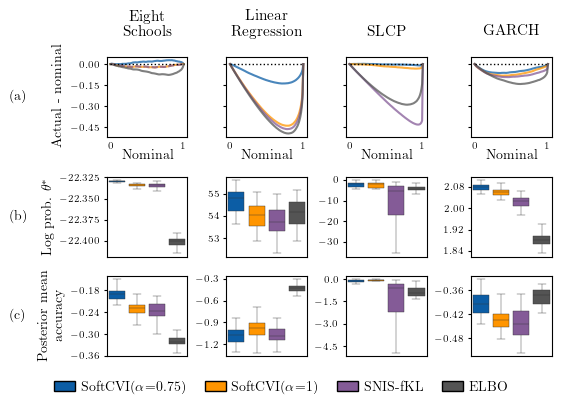

In [3]:
# We put the legend in its own subfigure, otherwise it is cut off when saving.
# We could use "bbox_inches="tight", but we want figure width == \textwidth
total_fig = plt.figure(
    layout='constrained',
    figsize=(plt.rcParams['figure.figsize'][0], 4),
    )

fig, legend_fig = total_fig.subfigures(
    nrows=2,
    height_ratios=[10, 1],
    )

axes = fig.subplots(nrows=3, ncols=len(tasks))

# Convert axes to a more convenient structure
coverage_axes, log_prob_axes, posterior_mean_axes = axes


def will_overlap(y, previous_ys, threshold=0.01):
    if len(previous_ys) == 0:
        return False
    return any(np.mean(np.abs(y-py)) < threshold for py in previous_ys)

####### Coverage ######
nominal_frequency = np.linspace(0, 1, 100)

for (task_name, task_result), ax in zip(results.items(), coverage_axes, strict=False):
    ax.set_title(task_name, y=1.15)
    ax.set_xlabel("Nominal", labelpad=0)

    prev_diffs = []
    for method in method_names:
        coverage_probs = task_result[method]["coverage_probabilities"]
        diff = np.mean(coverage_probs, axis=0) - nominal_frequency
        ax.plot(
            nominal_frequency,
            diff,
            color=palette[method],
            alpha=0.75,
            linewidth=1.5,
            linestyle=(0, (3, 1)) if will_overlap(diff, prev_diffs) else "-",
        )
        prev_diffs.append(diff)

    ax.plot([0, 1], [0, 0], color="black", linewidth=1, linestyle="dotted")


####### log prob true #######

for task_result, ax in zip(results.values(), log_prob_axes, strict=False):
    df = pd.concat([
        pd.DataFrame({method_name: task_result[method_name]["mean_log_prob_reference"]})
        for method_name in method_names
    ], axis=1)

    sns.boxplot(df, ax=ax, **box_kwargs)

### Negative posterior mean l2 ###

for task_result, ax in zip(results.values(), posterior_mean_axes, strict=False):
    df = pd.concat([
        pd.DataFrame(
            {method_name: task_result[method_name]["negative_posterior_mean_l2"]},
            )
        for method_name in method_names
    ], axis=1)
    sns.boxplot(df, ax=ax, **box_kwargs)

coverage_axes[0].set_ylabel("Actual - nominal")
log_prob_axes[0].set_ylabel(r"Log prob. $\theta^*$")
posterior_mean_axes[0].set_ylabel("Posterior mean \n accuracy")


for ax in axes.ravel():
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_box_aspect(1)
    ax.tick_params(axis="x", which="major", length=0)

for axs in [log_prob_axes, posterior_mean_axes]:
    for ax in axs:
        ax.tick_params("x", bottom=False)
        ax.xaxis.set_ticklabels([])

legend_fig.legend(handles=handles, ncols=4)

# Loop through the rows and label each one
for letter, ax in zip(["a", "b", "c"], axes[:, 0], strict=True):
    ax.text(-1.2, 0.5, f"({letter})", transform=ax.transAxes, va='center')

# Manually share axes for first row only
[a1.sharey(a2) for a1, a2 in zip(coverage_axes[:-1], coverage_axes[1:], strict=True)]
[ax.get_yaxis().set_ticklabels([]) for ax in coverage_axes[1:]]

total_fig.savefig(f"plots/plots/metrics_{hyparam_str}.pdf")



### Run times

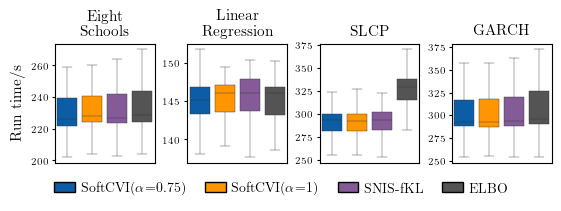

In [4]:
# We put the legend in its own subfigure, otherwise it is cut off when saving.
# We could use "bbox_inches="tight", but we want figure width == \textwidth
total_fig = plt.figure(
    layout='constrained',
    figsize=(plt.rcParams['figure.figsize'][0], 2),
    )
fig, legend_fig = total_fig.subfigures(nrows=2, height_ratios=[5, 1])
axes = fig.subplots(ncols=len(tasks))


for (task_name, task_result), ax in zip(results.items(), axes, strict=True):
    df = pd.concat([
        pd.DataFrame({method_name: task_result[method_name]["run_time"]})
        for method_name in method_names
    ], axis =1)
    sns.boxplot(df, ax=ax, **box_kwargs)
    ax.set_title(task_name.replace("_", "\n")) 

axes[0].set_ylabel("Run time/s", fontsize=11)
legend_fig.legend(handles=handles, ncols=4)
    
for ax in axes:
    ax.tick_params("x", bottom=False)
    ax.xaxis.set_ticklabels([])

total_fig.savefig(f"plots/plots/run_times_{hyparam_str}.pdf")